# Utiliser le modèle d'entrée pour faire l'entrée du ring et voir que ça march bien

### Le firing rate moyen d'un neurone V1 en fonction de l'angle : 40 a pic (Henry et al, 74 ; Dayan Abbot fg 1.5)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
import Spiking_LGN as SpiLGN
import datetime

import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import lmfit
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


In [2]:
from pyNN.space import *

class RingTopology(BaseStructure):
    parameter_names = 'radius'

    def __init__(self, radius):
        self.radius = radius

    def generate_positions(self, n):
        return np.array([
            np.cos(np.linspace(0, 2*np.pi, n))+(self.radius-1),
            np.sin(np.linspace(0, 2*np.pi, n))+(self.radius-1),
            np.zeros(n)
        ])
        # must return a 3xn numpy array

In [202]:
def tuning_function(x, j, B, fmax):  # von mises
    N = len(x)
    if B == np.inf:
        VM = np.ones_like(x)
    else:
        VM = np.exp((np.cos(2.*np.pi*(x-j)/N)-1.)/4/(B*np.pi/180)**2)
    #VM /= VM.sum(axis=0)
    return fmax * VM


def fit_plot(popsize, spike_array, ax, datacol='.r', fitcol='--k', data_kws=None, do_title=True,
             seq_nbr=None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''

    # fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array
    N = len(spike_array)

    #mod = GaussianModel()
    from lmfit import Model, Parameters
    mod = Model(tuning_function)
    pars = Parameters()
    pars.add_many(('j', y.argmax(), True,  0.0, N), ('B', 15., True,  0.1, 360),
                  ('fmax', y.max(), True,  0.0, 200.))

    #pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x, nan_policy='omit')
    # print(out.fit_report(min_correl=0.25))

    # plot the fits
    out.plot_fit(ax=ax, datafmt=datacol, fitfmt=fitcol,
                 data_kws=data_kws, show_init=False)

    # eye cancer-triggering lines
    sigma = out.best_values['B']

    if do_title:
        ax.set_title('Activité à %.2f ms -- ' % float((1000/9)*(seq_nbr)) + r'$B_\theta$ = %.2f' % sigma)

    return ax, sigma


def cut_spiketrain(array, window, total_time, nbr_window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype=float)

        spiketrain_cut = np.where(
            (spiketrain_array > window*int(total_time/nbr_window)) & (spiketrain_array < (window+1)*int(total_time/nbr_window)))[0]

        spiketrain_len.append(len(spiketrain_cut))

    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

def cut_list(lst, window, total_time, nbr_window):

    spike_cut = []
    for it, spike_array, in enumerate(lst) :
        density = np.where( (spike_array>window*int(total_time/nbr_window)) & (spike_array < (window+1)*int(total_time/nbr_window)))[0]
        spike_cut.append(len(density)/2.5)
    return spike_cut

In [198]:
def SuperPlotter(SpikesP, SpikesE, SpikesI,
                 popsize, simtime, nbr_window,
                 title='Title', markersize=.5,
                 figsize=(9, 6), shifts=None):
    # oh la jolie double fonction
    def plot_spiketrains(ax, spikes, color, ylabel, do_ticks):
        for spiketrain in spikes.spiketrains:
            y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
            ax.scatter(spiketrain, y, color=color, s=markersize)
            ax.set_ylabel(ylabel)
            if not do_ticks:
                ax.set_xticklabels([])
            if shifts != None:
                for i, times in enumerate(shifts):
                    ax.axvline(x=times, color='k',
                               linestyle='-.', linewidth=1)

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(5, 10)
    
    axs1 = plt.subplot(gs[0, :4])
    axs2 = plt.subplot(gs[1, :4])
    axs3 = plt.subplot(gs[2, :4])

    axs4a = plt.subplot(gs[0:1, 4:6])
    axs4b = plt.subplot(gs[0:1, 6:8])
    axs4c = plt.subplot(gs[0:1, 8:10])
    
    axs5a = plt.subplot(gs[1:2, 4:6])
    axs5b = plt.subplot(gs[1:2, 6:8])
    axs5c = plt.subplot(gs[1:2, 8:10])
    
    axs6a = plt.subplot(gs[2:3, 4:6])
    axs6b = plt.subplot(gs[2:3, 6:8])
    axs6c = plt.subplot(gs[2:3, 8:10])

    #SPECIAL MODIF TO USE P INPUT AS LIST
    for it, spike_array, in enumerate(SpikesP) :
        axs1.scatter(spike_array, np.full_like(spike_array, it), color = 'green', s = markersize)

    axs1.set_title('Entrée visuelle')
    axs1.set_yticklabels([])
    axs1.set_ylabel('Neurone')
    axs1.set_xticklabels([])
    
    
    #ring1
    plot_spiketrains(axs2, SpikesI, color='b',
                     ylabel='Neurone', do_ticks=False)
    axs2.set_title('Pop. Inhibitrice de la couche 2')
    plot_spiketrains(axs3, SpikesE, color='r',
                     ylabel='Neurone', do_ticks=True)
    axs3.set_title('Pop. Excitatrice de la couche 2')

    axs3.set_xlabel('Temps (ms)')
    
    axs4a.plot(np.linspace(0, popsize, 12),cut_list(SpikesP, 0,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 0,simtime, nbr_window), axs4a, seq_nbr=1)[1]
    axs4a.set_xticklabels([])
    axs4a.set_yticklabels([])
    axs4a.set_xlabel('')
    axs4a.set_ylabel('')
    
    axs5a.plot(np.linspace(0, popsize, 12),cut_list(SpikesP, 1,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 1,simtime, nbr_window), axs5a, seq_nbr=2)[1]
    axs5a.set_xticklabels([])
    axs5a.set_yticklabels([])
    axs5a.set_xlabel('')
    axs5a.set_ylabel('')
    
    axs6a.plot(np.linspace(0, popsize, 12),cut_list(SpikesP, 2,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 2,simtime, nbr_window), axs6a, seq_nbr=3)[1]
    axs6a.set_xticklabels([])
    axs6a.set_yticklabels([])
    axs6a.set_xlabel('')
    axs6a.set_ylabel('')

    axs4b.plot(np.linspace(0, popsize, 12),cut_list(SpikesP, 3,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 3,simtime, nbr_window), axs4b, seq_nbr=4)[1]
    axs4b.set_xticklabels([])
    axs4b.set_yticklabels([])
    axs4b.set_xlabel('')
    axs4b.set_ylabel('')
    
    axs5b.plot(np.linspace(0, popsize, 12),cut_list(SpikesP, 4,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 4,simtime, nbr_window), axs5b, seq_nbr=5)[1]
    axs5b.set_xticklabels([])
    axs5b.set_yticklabels([])
    axs5b.set_xlabel('')
    axs5b.set_ylabel('')
    
    axs6b.plot(np.linspace(0, popsize, 12),cut_list(SpikesP, 5,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 5,simtime, nbr_window), axs6b, seq_nbr=6)[1]
    axs6b.set_xticklabels([])
    axs6b.set_yticklabels([])
    axs6b.set_xlabel('')
    axs6b.set_ylabel('')
    
    axs4c.plot(np.linspace(0, popsize, 12),cut_list(SpikesP, 6,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 6,simtime, nbr_window), axs4c, seq_nbr=7)[1]
    axs4c.set_xticklabels([])
    axs4c.set_yticklabels([])
    axs4c.set_xlabel('')
    axs4c.set_ylabel('')
    
    axs5c.plot(np.linspace(0, popsize, 12),cut_list(SpikesP, 7,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 7,simtime, nbr_window), axs5c, seq_nbr=8)[1]
    axs5c.set_xticklabels([])
    axs5c.set_yticklabels([])
    axs5c.set_xlabel('')
    axs5c.set_ylabel('')
    
    axs6c.plot(np.linspace(0, popsize, 12),cut_list(SpikesP, 8,simtime, nbr_window), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 8,simtime, nbr_window), axs6c, seq_nbr=9)[1]
    axs6c.set_xticklabels([])
    axs6c.set_yticklabels([])
    
    axs6c.yaxis.tick_right()
    axs6c.yaxis.set_label_position("right")
    axs6c.set_xlabel('Neurone')
    axs6c.set_ylabel('Nombre de P.A.')
    
    axs6c.legend(labels=['Entrée', 'Exc.', 'VonMises'])
    
    plt.show()
    return fig

### Unmarkdown either one of the cells below to (1) rerun currents or to (2) load previously generated currents

In [194]:
#Loading MotionClouds
video = np.load('./MotionClouds_64x64x128_24FPS.npy')
print('MotionCloud shape', video.shape)

output_currents = SpiLGN.input_to_currents(video=video, FPS=24., total_time=1000,
                                           distrib_size=10, safeguard_offset=20, random_shift=1, grid_res=3,
                                           N_theta=12, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 1,
                                           n_jobs=-1, backend='loky', mt_verbose=10)

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H_%M")   
np.savez_compressed('./output/%s'%strtime, output_currents)

MotionCloud shape (64, 64, 128)
Video shape (64, 64, 128)
Frames per second: 24.0
Frame duration at 24.0 FPS: 41.67 ms
Video length inferred from fps: 6 s
FPS conversion sanity check passed !

Stimuli shape (64, 64, 1000)
Generating filters coordinates with gabors ..


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    2.0s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    2.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    2.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    2.0s remaining:    0.7s


KeyboardInterrupt: 

In [6]:
load_npz = np.load('./output/%s.npz'%strtime)
load_arr = load_npz['arr_0.npy']

In [7]:
load_arr.shape

(12, 16, 2)

In [8]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 1000
rng = sim.NumpyRNG(seed=42)

rate_gain = 20.  # multiplier for the rates
angle_input = 40  # degrees
b_theta = 15  # degrees
nbr_window = 9

In [140]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }

gain = .2
injection_sampling_rate = 1
total_time = len(load_arr[0][0][0][0])

current_times = np.linspace(0,total_time,total_time/injection_sampling_rate)

fr_list = []
#we'll loop through 12 thetas but keep the same cell location (gabor : 0)
for theta,_ in enumerate(load_arr) :
    running_theta = theta*(np.pi/12)*180/np.pi
    
    current_levels = load_arr[theta][2] #gabor 0
    
    ##############
    # Simulation #
    ##############
    sim.setup(timestep=0.1)

    post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                        initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


    #injecting all ON cells current
    for inputs in range(len(current_levels[0])):

        current_level = current_levels[0][inputs][::injection_sampling_rate]
        current_level = np.asarray(current_level)

        current_input = sim.StepCurrentSource(times = current_times,
                                         amplitudes = current_level*gain)
        current_input.inject_into(post)
        current_input.record()

    #injecting all OFF cells current
    for inputs in range(len(current_levels[1])):

        current_level = current_levels[1][inputs][::injection_sampling_rate]
        current_level = np.asarray(current_level)

        current_input = sim.StepCurrentSource(times = current_times,
                                         amplitudes = -current_level*(gain/2))
        current_input.inject_into(post)
        current_input.record()

    post.record(['spikes', 'v'])

    sim.run(total_time)
    sim.end()
    fr_list.append(post.get_data().segments[0].spiketrains[0])

/home/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


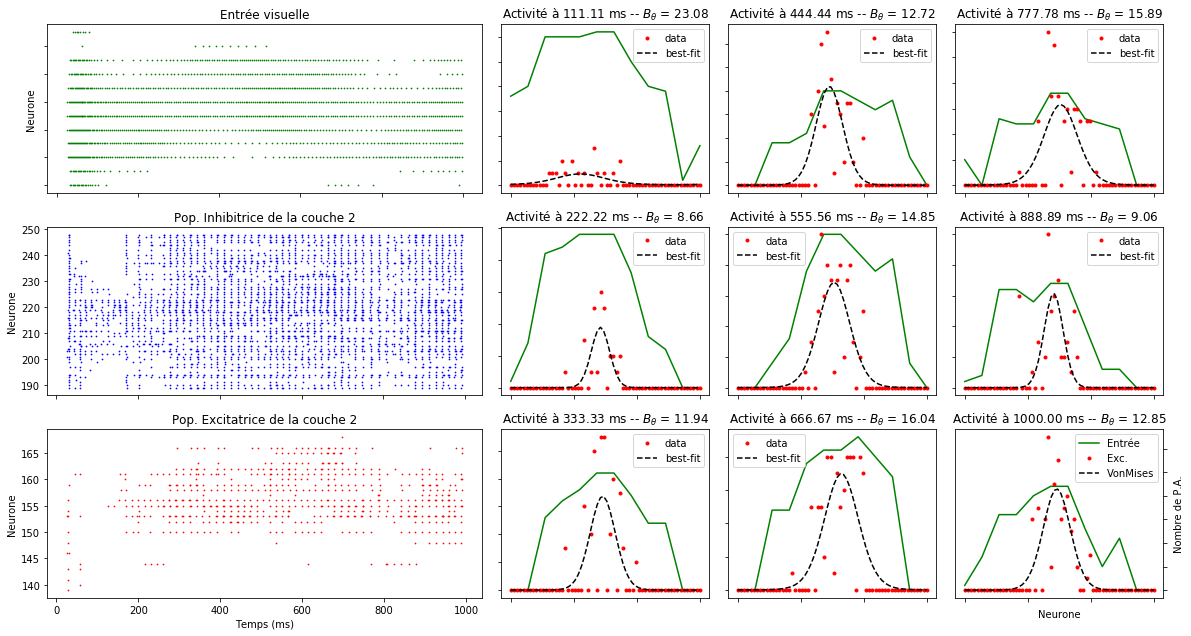

In [235]:
stdp_weight_init = .1
stdp_max_w = 2 * stdp_weight_init
normal_weights = stdp_weight_init

delays = rnd('normal_clipped', mu=3, sigma=5, low=0.1,
             high=5,
             rng=rng)

# la stdp normale
causal_hebian_timing_dependence = sim.SpikePairRule(tau_plus=30.*1.25, tau_minus=30.,
                                                    A_plus=.025*1.5, A_minus=.025)
# la stdp à l'envers
anticausal_hebian_timing_dependence = sim.SpikePairRule(tau_plus=30.*.75, tau_minus=30.,
                                                        A_plus=-.025*0.3, A_minus=-.025)
# la symétrique positive
causal_sym_timing_dependence = sim.SpikePairRule(tau_plus=30.*1.6, tau_minus=30.,
                                                 A_plus=.025, A_minus=-.025)
# la symétrique négative
anticausal_sym_timing_dependence = sim.SpikePairRule(tau_plus=30.*1, tau_minus=30.,
                                                     A_plus=-.025*1.75, A_minus=.025)


sim.setup(timestep=.1, threads=8)

#ring1
exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     structure=RingTopology(radius=2),
                     label="Neurones Exictateurs")
inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     structure=RingTopology(radius=2),
                     label="Neurones Inhibiteurs")
#ring2
exc2 = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     structure=RingTopology(radius=2),
                     label="Neurones Exictateurs 2")
inh2 = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     structure=RingTopology(radius=2),
                     label="Neurones Inhibiteurs 2")

# INPUT STDP
in_mult = 4
# input to exc, causal hebbian
in_causal_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=in_mult*stdp_max_w),
    weight=in_mult*stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
in_mult = 1
# input to inh, anticausal hebbian
in_anticausal_STDP_syn = sim.STDPMechanism(
    timing_dependence=anticausal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=in_mult*stdp_max_w),
    weight=in_mult*stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# CAUSAL STDP
# syn exc_inh, hebbian causality
causal_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# ANTICAUSAL STDP
# syn inh exc, makes the inhibitory fire when exc is not firing
inh_anticausal_STDP_syn = sim.STDPMechanism(
    timing_dependence=anticausal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# SYMETRIC POSITIVE STDP
# syn exc exc, reinforcing
sim_plus_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_sym_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
# syn inh inh, reinforcing inhibition
inh_sim_plus_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_sym_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

c2_mult = 5
STDP_exc_exc2 = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=stdp_max_w*c2_mult),
    weight=stdp_weight_init*c2_mult,
    delay=delays,
    dendritic_delay_fraction=1.)
STDP_exc_inh2 = sim.STDPMechanism(
    timing_dependence=anticausal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=stdp_max_w*c2_mult),
    weight=stdp_weight_init*c2_mult,
    delay=delays,
    dendritic_delay_fraction=1.)
STDP_inh_exc2 = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-stdp_max_w*c2_mult),
    weight=-stdp_weight_init*c2_mult,
    delay=delays,
    dendritic_delay_fraction=1.)

    
# Intras
syn_exc_exc = sim.Projection(exc, exc,
                             connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                 allow_self_connections=False),
                             synapse_type=sim_plus_STDP_syn)
syn_inh_inh = sim.Projection(inh, inh,
                             connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                 allow_self_connections=False),
                             synapse_type=inh_sim_plus_STDP_syn)
# Inters
syn_exc_inh = sim.Projection(exc, inh,
                             connector=sim.AllToAllConnector(
                                 allow_self_connections=False),
                             synapse_type=causal_STDP_syn)
syn_inh_exc = sim.Projection(inh, exc,
                             connector=sim.AllToAllConnector(
                                 allow_self_connections=False),
                             synapse_type=inh_anticausal_STDP_syn)


#Intras 2
syn_exc2_exc2 = sim.Projection(exc2, exc2,
                             connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                 allow_self_connections=False),
                             synapse_type=sim_plus_STDP_syn)
syn_inh2_inh2 = sim.Projection(inh2, inh2,
                             connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                 allow_self_connections=False),
                             synapse_type=inh_sim_plus_STDP_syn)
#Inters 2
syn_exc2_inh2 = sim.Projection(exc2, inh2,
                             connector=sim.AllToAllConnector(
                                 allow_self_connections=False),
                             synapse_type=causal_STDP_syn)
syn_inh2_exc2 = sim.Projection(inh2, exc2,
                             connector=sim.AllToAllConnector(
                                 allow_self_connections=False),
                             synapse_type=inh_anticausal_STDP_syn)
#Ring 1 to Ring 2
#feedforward
syn_exc_exc2 = sim.Projection(exc, exc2,
                             connector=sim.OneToOneConnector(),
                             synapse_type=STDP_exc_exc2)
#feedforward to inhi
syn_exc_inh2 = sim.Projection(exc, inh2,
                             connector=sim.OneToOneConnector(),
                             synapse_type=STDP_exc_inh2)

#feedforward inhibition
syn_inh_exc2 = sim.Projection(inh, exc2,
                             connector=sim.OneToOneConnector(),
                             synapse_type=STDP_inh_exc2)

syn_exc2_exc2 = sim.Projection(exc2, exc2,
                             connector=sim.DistanceDependentProbabilityConnector("exp(5*-d)",
                                                                                 allow_self_connections=False),
                             synapse_type=sim_plus_STDP_syn)
syn_inh2_inh2 = sim.Projection(inh2, inh2,
                             connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                 allow_self_connections=False),
                             synapse_type=inh_sim_plus_STDP_syn)
input_list = []

for theta, post_spikes in enumerate(fr_list) :
    seq = sim.Population(1,
                         sim.SpikeSourceArray(spike_times=Sequence(np.asarray(post_spikes))))
    syn_inp_exc = sim.Projection(seq, exc[theta*5:(theta+1)*5],
                             connector=sim.AllToAllConnector(),
                             synapse_type=in_causal_STDP_syn)
    syn_inp_inh = sim.Projection(seq, inh[theta*5:(theta+1)*5],
                             connector=sim.AllToAllConnector(),
                             synapse_type=in_anticausal_STDP_syn)
    seq.record('spikes')
    input_list.append(seq)


    
    
exc.record('spikes')
inh.record('spikes')
exc2.record('spikes')
inh2.record('spikes')
sim.run(simtime)
sim.end()

exc_data = exc.get_data().segments[0]
inh_data = inh.get_data().segments[0]
exc2_data = exc2.get_data().segments[0]
inh2_data = inh2.get_data().segments[0]

seq_datas = []
for input_neuron in input_list :
    dat = input_neuron.get_data().segments[0].spiketrains[0]
    seq_datas.append(dat)

fig = SuperPlotter(seq_datas, 
                   exc2_data, inh2_data,
                   60, simtime, nbr_window,
                   figsize=(20, 18)
                   )
plt.show()

fig.savefig('./figs/FINAL_visuo_to_ring.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')